## Isolation Forest: Analyzing the Results

* Isolation Forest: Use an ensemble of shallow binary trees that split the data into two groups.
    * At each iteration, a boundary line is drawn across the dataset, and each point is given a score
        * The score is the fraction of all points on either side of the boundary line
        * The overall outlier score is the average score across each iteration
        * Points that are located further away from the main cluster are more likely to be separated and should have lower scores

In [290]:
### Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D

import ipyleaflet as ipy

from pyspark import SparkContext
import pyspark.sql.functions as F
import pyspark.ml.functions as M
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql import Window as W
from pyspark.sql.types import *
from pyspark.ml.feature import PCA, VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation, Summarizer

import time
import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [2]:
### Notes from prof's example notebook
# #Make sure you allocate enough memory per core. if you chose 3 cores you should select 6GB in your per Node setting. (presumably 2GB per core)

### For server
# 32 nodes
# 64g

## Start Spark context
total_nodes = 4
memory_per_node = 64

driver_memory = f"{memory_per_node}g"
executor_memory = f"{int(memory_per_node/total_nodes)}g"
n_executors = total_nodes - 1
print(f"Driver memory: {driver_memory}\nExecutor memory: {executor_memory}\nNumber of executors: {n_executors}\n")
try:
    print("Initializing SparkContext")
    sc = SparkSession.builder.config("spark.driver.memory", driver_memory) \
                             .config("spark.executor.memory", executor_memory) \
                             .config('spark.local.dir', "test_dir/") \
                             .config("spark.driver.maxResultSize", "16g") \
                             .config("spark.executor.instances", n_executors) \
                             .getOrCreate()
    
                             # .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:0.9.4") \
                             # .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven") \
except:
    print("Starting new SparkContext")
    sc.stop()
    sc = SparkSession.builder.config("spark.driver.memory", driver_memory) \
                             .config("spark.executor.memory", executor_memory) \
                             .config('spark.local.dir', "test_dir/") \
                             .config("spark.driver.maxResultSize", "16g") \
                             .config("spark.executor.instances", n_executors) \
                             .appName("MyApp") \
                             .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:0.9.4") \
                             .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven") \
                             .getOrCreate()
print(sc)

# Start SQL Context
sqlContext = SQLContext(sc)

# Add sc parameters
sc.getActiveSession()
# sc.builder.appName("Read CSV").getOrCreate()
# sc.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

Driver memory: 64g
Executor memory: 16g
Number of executors: 3

Initializing SparkContext


/usr/local/spark/python/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:
%%time
### Load datasets

### Open the preprocessed dataset
df_base = sqlContext.read.load("preprocessed_df_subset/preprocessed_df_subset.parquet")
# df = sqlContext.read.load("datasets/df_iforest_7trees_10splits/part*.parquet")

# metadata
meta_filename = "metadata_preprocessed.csv"
df_meta = sc.read.csv(meta_filename, inferSchema=True, header=True)

### Since metadata table is so small, convert to Pandas
df_meta = df_meta.toPandas()

# df.printSchema()


CPU times: user 93.5 ms, sys: 14.4 ms, total: 108 ms
Wall time: 4.84 s


In [4]:
%%time
### Load the individual results
df_1t10s = sqlContext.read.load("datasets/df_iforest_1trees_10splits/part*.parquet")
df_1t30s = sqlContext.read.load("datasets/df_iforest_1trees_30splits/part*.parquet")
df_3t10s = sqlContext.read.load("datasets/df_iforest_3trees_10splits/part*.parquet")
df_3t30s = sqlContext.read.load("datasets/df_iforest_3trees_30splits/part*.parquet")
df_5t10s = sqlContext.read.load("datasets/df_iforest_5trees_10splits/part*.parquet")
df_5t30s = sqlContext.read.load("datasets/df_iforest_5trees_30splits/part*.parquet")
df_7t10s = sqlContext.read.load("datasets/df_iforest_7trees_10splits/part*.parquet")
df_7t30s = sqlContext.read.load("datasets/df_iforest_7trees_30splits/part*.parquet")

CPU times: user 5.95 ms, sys: 198 µs, total: 6.15 ms
Wall time: 20.1 s


In [6]:
df_1t10s.printSchema()

root
 |-- id: long (nullable = true)
 |-- ss_id: long (nullable = true)
 |-- stamp_date: date (nullable = true)
 |-- recon_PC1: double (nullable = true)
 |-- recon_PC2: double (nullable = true)
 |-- recon_PC1_scaled: double (nullable = true)
 |-- recon_PC2_scaled: double (nullable = true)
 |-- score_0_1t_10s: double (nullable = true)
 |-- score_1_1t_10s: double (nullable = true)
 |-- score_2_1t_10s: double (nullable = true)
 |-- 1t_10s_mean_score: double (nullable = true)
 |-- 1t_10s_std_score: double (nullable = true)



## What are Isolation Forests?

An isolation forest is an unsupervised machine learning algorithm which utilizes binary trees to detect anomalies. The algorithm relies on the fact that data points located further away from the centers of distribution are more likely to be quickly separated from the rest of the points when splitting the variable space.

A typical isolation forest follows these steps:
* For each tree:
    * Randomly sample a subset of the data points
    * Recursively split the space along random variables at random values until some stopping criterion (ex: until every leaf node contains 3 points at maximum)
    * Give each point a score which corresponds to how close its leaf node is to the root node
    * Average this score across multiple trees
 
However, Pyspark does not have any built-in isolation forest algorithms - instead, we use an ensemble of single-node binary trees and take the average score for each point.
* First get the minimum and maximum values of the two variables (here, PC1 and PC2)
* For each forest:
    * For each tree:
        * Pick two random points within the space and get the parameters of the line that connects them in standard form (Ax +  By + C = 0)
        * Split the points into two groups determined by what side of the line they are on
        * Give each point a score which corresponds to the fraction of all points that lie on the same side of the line
* These results are averaged across trees, and across forests.

This method relies on both randomness and weak learners, so there can be a lot of variability in results. Thus, averaging the results across multiple trees and even multiple forests is ideal.

In [7]:
### Isolation Forest Functions

def get_min_max_values(data, inputCols):
    # Get the min and max value of columns in inputCols, output dictionary of dict[col] = (min, max)
    return {i:data.select(F.min(col), F.max(col)).collect()[0] for i,col in enumerate(inputCols)}

def randomLine_parameters(data, min_max_dict, offset_size):
    # Pick two random points within the boundaries of inputCols, then determine the parameters for the resulting line
    # y-y1 = (y2-y1)/(x2-x1) * (x-x1)
    # --> (y1-y2)*x + (x2-x1)*y + (x1-x2)*y1 - (y2-y1)*x1 = 0

    # Get offsets --> This ensures the selected points are closer to the mean (and away from boundaries)
    # Having higher offsets is better when the data is more concentrated
    col1_offset = (min_max_dict[0][1] - min_max_dict[0][0]) * offset_size
    col2_offset = (min_max_dict[1][1] - min_max_dict[1][0]) * offset_size
    
    x1 = np.random.uniform(min_max_dict[0][0] + col1_offset, min_max_dict[0][1] - col1_offset)
    x2 = np.random.uniform(min_max_dict[0][0] + col1_offset, min_max_dict[0][1] - col1_offset)
    y1 = np.random.uniform(min_max_dict[1][0] + col2_offset, min_max_dict[1][1] - col2_offset)
    y2 = np.random.uniform(min_max_dict[1][0] + col2_offset, min_max_dict[1][1] - col2_offset)

    # Get line parameters in standardized form
    A = y2 - y1
    B = x1 - x2
    C = y1*(x2-x1) + x1*(y1-y2)
    line_params = (A, B, C)
    
    return line_params

def get_line_params(data, inputCols, num_splits, offset_size, min_max_dict=False):
    # Get a list of line parameters to randomly split values
    ############################################################################
    # Variables
    output = []
    if min_max_dict is False:
        min_max_dict = get_min_max_values(data, inputCols)
    
    ### Get a list of (A,B,C) tuples
    for i in np.arange(0, num_splits):
        output.append(randomLine_parameters(data, min_max_dict, offset_size))

    return output

def build_isolation_forest_simple(data, inputCols, outputCol, num_trees, num_splits, min_max_dict=False, offset_size = 0.001):
    ### Build a custom isolation forest (simplified without sampling or recursive structure)
    # Inputs:
    #    Data --> Input dataframe
    #    inputCols --> The columns to split on (recon_PC1 and recon_PC2 in this code)
    #    num_splits --> The number of splits to run on each tree
    #    random_offset --> An offset from the edges of the column split ranges to ensure the split stays within the range
    #
    # Determine a list of tuple-pairings of randomly selected columns and respective values to split on
    # For each split:
    #     Determine whether each point falls to the left (group 0) or right (group 1) of the split
    #     Count the number of points in group 0 and group 1
    #     Record the resulting fraction for each point and add the fraction to the running sum (tree_scoreSum)
    # After all splits are complete, take the average splitScore as scoreSum
    # After all trees are complete, take the average scoreSum and output as score
    #
    # Points that are outliers should have smaller scores than normal points

    # Record the columns and get row count
    print("Model Start")
    print()
    model_start = time.time()
    df_columns = data.schema.names

    # Initialize the score column and necessary columns to handle the sampling, id column
    output = data.withColumn(outputCol, F.lit(0))  \
                 .withColumn("scoreSum", F.lit(0))

    # Get the number of rows in the data
    rowCount = output.count()

    ### Start the trees
    for j in np.arange(0, num_trees):
        print(f"Tree {j+1}/{num_trees} start:")
        tree_start = time.time()
        # Find the columns and respective values to split on
        line_param_list = get_line_params(output, inputCols, num_splits, offset_size, min_max_dict)
        # Instantiate the tree_scoreSum column
        output = output.withColumn("tree_scoreSum", F.lit(0))
        
        ### Start the splits
        split_start = time.time()
        for i,(line_params) in enumerate(line_param_list):
            if (((i-1)%10 == 0) & (i!=0)):
                split_start = time.time()
            A,B,C = line_params
            # Mark each selected row as being on one side of the split
            output = output.withColumn("which_side", F.when(F.lit(A)*F.col(inputCols[0]) + F.lit(B)*F.col(inputCols[1]) + C >=0, 1).otherwise(0))
            # Get the fraction of rows on either side of the split
            group1 = output.select(F.sum("which_side")).collect()[0][0] / rowCount
            group0 = 1 - group1
    
            # For each selected row, assign group0 or group1 to splitScore
            output = output.withColumn("splitScore", F.when(F.col("which_side")==1, F.lit(group1)).otherwise(F.lit(group0))) \
    
            # Add the splitScore to the running total tree_scoreSum
            output = output.withColumn("tree_scoreSum", F.col("tree_scoreSum") + F.col("splitScore"))

            if ((i+1)%10) == 0:
                print(f"  Split {i+1}/{num_splits}: Time elapsed --> {time.time() - split_start}")
        ### Add the score to the overall running score total (scoreSum)
        output = output.withColumn("scoreSum", F.col("scoreSum") + (F.col("tree_scoreSum") / F.lit(num_splits)))
        
        print(f"Tree {j+1}:  Time elapsed --> {time.time() - tree_start}")
        print()

    # Add the average score
    output = output.withColumn(outputCol, F.round(F.col("scoreSum") / F.lit(num_trees), 5))

    ### Calculate the overall score and output it
    output = output.select(df_columns + [outputCol]) \
                   .orderBy(outputCol, ascending=True)
    
    print(f"Model complete: Time elapsed --> {time.time() - model_start}")
    return output


In [48]:
# Demonstrating the splits
df = df_1t10s

df_iforest = df_1t10s
inputCols = ["recon_PC1", "recon_PC2"]
random_offset = 0.1 ## This parameter helps ensure the splitting lines remain closer to the mean

# Get input columns and corresponding min/max values
min_max_dict = get_min_max_values(df_iforest, inputCols)

col1_offset = (min_max_dict[0][1] - min_max_dict[0][0]) * (1/20)
col2_offset = (min_max_dict[1][1] - min_max_dict[1][0]) * (1/20)

for item in min_max_dict.items():
    print(item)

(0, Row(min(recon_PC1)=-7.031215404680069, max(recon_PC1)=0.9817973693571098))
(1, Row(min(recon_PC2)=-0.7223526339584964, max(recon_PC2)=0.7194646672990974))


In [9]:
# Get df for plotting example
pc1_mean, pc2_mean = df.select(F.avg("recon_PC1"), F.avg("recon_PC2")).collect()[0]
pd_df = df.select("recon_PC1", "recon_PC2").sample(fraction=0.35).toPandas()

744 examples in group 0 --> Score = 8e-05 (744/9833053)
9832309 examples in group 1 --> Score = 0.99992 (9832309/9833053)

9475216 examples in group 0 --> Score = 0.96361 (9475216/9833053)
357837 examples in group 1 --> Score = 0.03639 (357837/9833053)

3503763 examples in group 0 --> Score = 0.35633 (3503763/9833053)
6329290 examples in group 1 --> Score = 0.64367 (6329290/9833053)

54 examples in group 0 --> Score = 1e-05 (54/9833053)
9832999 examples in group 1 --> Score = 0.99999 (9832999/9833053)



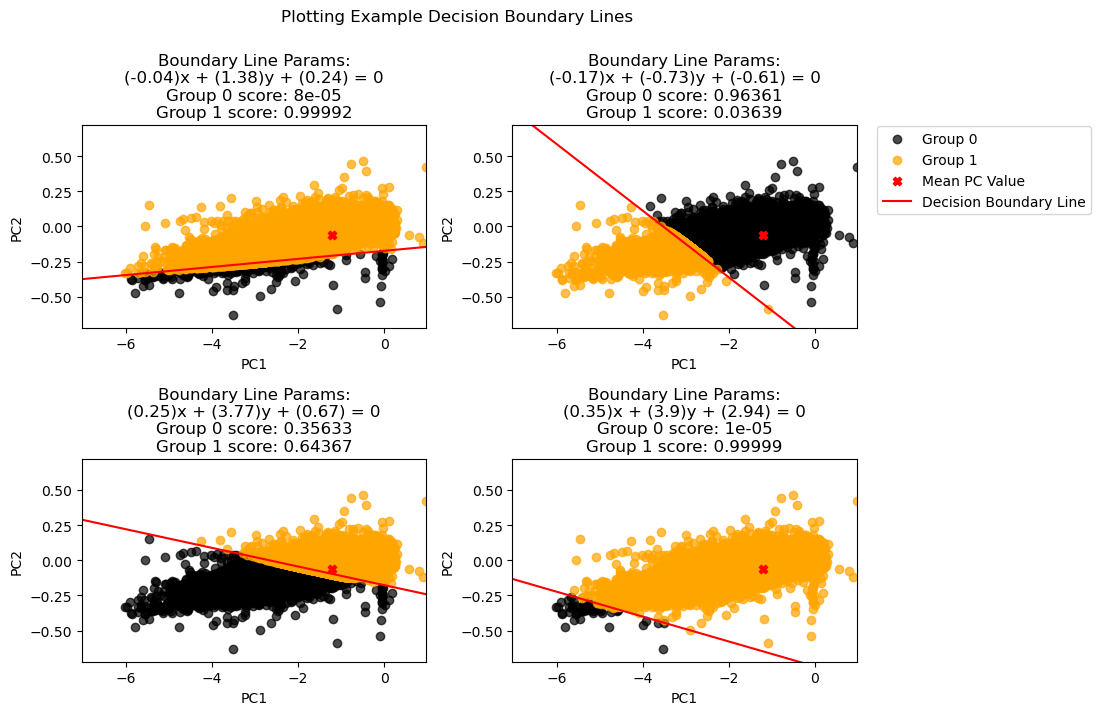

In [10]:
### Plotting results ---> Re-run this cell to generate new plots

# randomLine_parameters(data, min_max_dict, offset_size)

offset_size = 0.05
pd_count = len(pd_df)

fig,axes = plt.subplots(2,2, figsize=(10,7.5))
for i,ax in enumerate(axes.flatten()):
    A, B, C = randomLine_parameters(df_iforest, min_max_dict, offset_size=0.1)
    x = np.linspace(min_max_dict[0][0], min_max_dict[0][1], 5)
    y = (-A/B)*x + -(C/B)
    pd_df["prediction"] = np.sign(A*pd_df["recon_PC1"] + B*pd_df["recon_PC2"] + C)
    
    # Calculate Values
    n_group0 = len(pd_df[pd_df["prediction"]==-1])
    n_group1 = len(pd_df[pd_df["prediction"]==1])
    ax_title = f"Group 0 score: {np.round((n_group0/pd_count),5)}\nGroup 1 score: {np.round((n_group1/pd_count),5)}"

    # Plot original plot
    ax.scatter(pd_df[(pd_df["prediction"]==-1)]["recon_PC1"], 
                 pd_df[(pd_df["prediction"]==-1)]["recon_PC2"], 
                 alpha=0.7, color="k", label="Group 0")
    ax.scatter(pd_df[pd_df["prediction"]==1]["recon_PC1"], 
                pd_df[pd_df["prediction"]==1]["recon_PC2"], 
                alpha=0.7, color="orange", label="Group 1")
    ax.scatter(pc1_mean, pc2_mean, marker="X", c="r", label="Mean PC Value")
    ax.plot(x,y, color="r", label="Decision Boundary Line")
    ax_title
    ax.set_title(f"Boundary Line Params:\n({np.round(A,2)})x + ({np.round(B,2)})y + ({np.round(C,2)}) = 0\n{ax_title}")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_xlim([min_max_dict[0][0], min_max_dict[0][1]])
    ax.set_ylim([min_max_dict[1][0], min_max_dict[1][1]])
    if i==1:
        ax.legend(loc="upper right", bbox_to_anchor=(1.7, 1.03))

    print(f"{n_group0} examples in group 0 --> Score = {np.round((n_group0/pd_count),5)} ({n_group0}/{pd_count})")
    print(f"{n_group1} examples in group 1 --> Score = {np.round((n_group1/pd_count),5)} ({n_group1}/{pd_count})")
    print()


plt.suptitle("Plotting Example Decision Boundary Lines")
plt.subplots_adjust(wspace=0.25, hspace=0.65, top=0.825)

plt.tight_layout
plt.show()

# Analyzing I-Forest Results

In [29]:
### Get aggregate stats on the mean runs
# String variables
mean_str = "_mean_score"
std_str = "_std_score"
runs = ["1t_10s", "1t_30s", "3t_10s", "3t_30s", "5t_10s", "5t_30s", "7t_10s", "7t_30s"]

mean_columns = [run+mean_str for run in runs]
std_columns = [run+std_str for run in runs]
df_columns = ["id", "ss_id", "stamp_date", "recon_PC1", "recon_PC2"]
power_columns = ["power_kW_values", "reconstructions"]
#########################################################################################
agg_mean_stats = list(eval(", ".join([f"F.min(F.col(\'{col}\')), F.max(F.col(\'{col}\')), F.avg(F.col(\'{col}\')), F.std(F.col(\'{col}\'))" for col in mean_columns])))
print(agg_mean_stats)

[Column<'min(1t_10s_mean_score)'>, Column<'max(1t_10s_mean_score)'>, Column<'avg(1t_10s_mean_score)'>, Column<'std(1t_10s_mean_score)'>, Column<'min(1t_30s_mean_score)'>, Column<'max(1t_30s_mean_score)'>, Column<'avg(1t_30s_mean_score)'>, Column<'std(1t_30s_mean_score)'>, Column<'min(3t_10s_mean_score)'>, Column<'max(3t_10s_mean_score)'>, Column<'avg(3t_10s_mean_score)'>, Column<'std(3t_10s_mean_score)'>, Column<'min(3t_30s_mean_score)'>, Column<'max(3t_30s_mean_score)'>, Column<'avg(3t_30s_mean_score)'>, Column<'std(3t_30s_mean_score)'>, Column<'min(5t_10s_mean_score)'>, Column<'max(5t_10s_mean_score)'>, Column<'avg(5t_10s_mean_score)'>, Column<'std(5t_10s_mean_score)'>, Column<'min(5t_30s_mean_score)'>, Column<'max(5t_30s_mean_score)'>, Column<'avg(5t_30s_mean_score)'>, Column<'std(5t_30s_mean_score)'>, Column<'min(7t_10s_mean_score)'>, Column<'max(7t_10s_mean_score)'>, Column<'avg(7t_10s_mean_score)'>, Column<'std(7t_10s_mean_score)'>, Column<'min(7t_30s_mean_score)'>, Column<'max(7

In [30]:
df_5t10s.show(1, vertical=True)

df_1t10s.show(1, vertical=True)

-RECORD 0--------------------------------
 id                | 326417867170        
 ss_id             | 23989               
 stamp_date        | 2018-08-02          
 recon_PC1         | -3.4234604795433348 
 recon_PC2         | -0.1985993577523102 
 recon_PC1_scaled  | 0.45023701158023316 
 recon_PC2_scaled  | 0.3632591145558829  
 score_0_5t_10s    | 0.77112             
 score_1_5t_10s    | 0.70324             
 score_2_5t_10s    | 0.78957             
 5t_10s_mean_score | 0.7546433333333332  
 5t_10s_std_score  | 0.00413365526666667 
only showing top 1 row

-RECORD 0--------------------------------
 id                | 120259583323        
 ss_id             | 12124               
 stamp_date        | 2019-06-22          
 recon_PC1         | -3.3234795435214886 
 recon_PC2         | -0.1553863957190487 
 recon_PC1_scaled  | 0.46271433301241566 
 recon_PC2_scaled  | 0.39323029189962116 
 score_0_1t_10s    | 0.83323             
 score_1_1t_10s    | 0.59032             
 score_2_1

In [33]:
%%time
### Get aggregate stats on the mean runs
# String variables
mean_str = "_mean_score"
std_str = "_std_score"
runs = ["1t_10s", "1t_30s", "3t_10s", "3t_30s", "5t_10s", "5t_30s", "7t_10s", "7t_30s"]
dfs = [df_1t10s, df_1t30s, df_3t10s, df_3t30s, df_5t10s, df_5t30s, df_7t10s, df_7t30s]

df_columns = ["id", "ss_id", "stamp_date", "recon_PC1", "recon_PC2"]
power_columns = ["power_kW_values", "reconstructions"]
#########################################################################################
agg_mean_stats = list(eval(", ".join([f"F.min(F.col(\'{col}\')), F.max(F.col(\'{col}\')), F.avg(F.col(\'{col}\')), F.std(F.col(\'{col}\'))" for col in mean_columns])))
# mean_results = df.select(agg_mean_stats).toPandas()
start = 0
for i,(df0,run) in enumerate(zip(dfs,runs)):
    # String variables 
    mean_col = run+mean_str
    std_col = run+std_str
    agg_mean_stats = list(eval(f"F.min(F.col(\'{mean_col}\')), F.max(F.col(\'{mean_col}\')), F.avg(F.col(\'{mean_col}\')), F.std(F.col(\'{mean_col}\'))"))
    agg_std_stats = list(eval(f"F.min(F.col(\'{std_col}\')), F.max(F.col(\'{std_col}\')), F.avg(F.col(\'{std_col}\')), F.std(F.col(\'{std_col}\'))"))

    print(run)
    overall_results = df0.select(agg_mean_stats).collect()[0]
    print("Mean Stats")
    print(f"\tMin: {overall_results[0]}, Max: {overall_results[1]}\n\tMean: {overall_results[2]}, Std: {overall_results[3]}\n")
    overall_results = df0.select(agg_std_stats).collect()[0]
    print("Standard Deviation Stats")
    print(f"\tMin: {overall_results[0]}, Max: {overall_results[1]}\n\tMean: {overall_results[2]}, Std: {overall_results[3]}\n")


1t_10s
Mean Stats
	Min: 0.37776000000000004, Max: 0.93569
	Mean: 0.8530719952682713, Std: 0.08280484375747811

Standard Deviation Stats
	Min: 0.00016964719999999973, Max: 0.10152589306666669
	Mean: 0.013448749824140557, Std: 0.014449567444131853

1t_30s
Mean Stats
	Min: 0.34201333333333334, Max: 0.9742633333333334
	Mean: 0.9374311377727713, Std: 0.03787861306257437

Standard Deviation Stats
	Min: 6.8604666666667104e-06, Max: 0.031954970399999984
	Mean: 0.0012655977627952534, Std: 0.0013155982817294174

3t_10s
Mean Stats
	Min: 0.4348133333333333, Max: 0.9590500000000001
	Mean: 0.9066492876845813, Std: 0.04113710213176326

Standard Deviation Stats
	Min: 3.806666666664437e-08, Max: 0.016095633866666664
	Mean: 0.003298760688556448, Std: 0.0016430677692949795

3t_30s
Mean Stats
	Min: 0.43832999999999994, Max: 0.9637566666666667
	Mean: 0.9126275632802985, Std: 0.049928403062812175

Standard Deviation Stats
	Min: 7.393999999999224e-07, Max: 0.008385067400000005
	Mean: 0.0007002673179723009, S

In [5]:
df = df_5t30s
mean_col = "5t_30s_mean_score"
std_col = "5t_30s_std_score"
print(df.select(F.avg(mean_col), F.avg(std_col)).collect())

[Row(avg(5t_30s_mean_score)=0.9035789492753317, avg(5t_30s_std_score)=0.0002925752313341332)]


The model with the least variance in output scores for each individual point is 5 trees with 30 splits



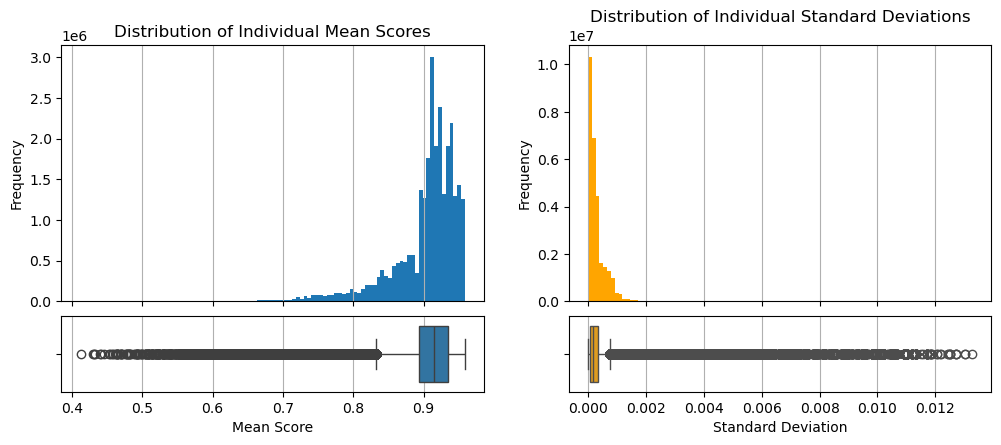

CPU times: user 2min, sys: 7.08 s, total: 2min 7s
Wall time: 2min 12s


In [45]:
%%time
### Compare variances, then analyze the one with the least variance
print("The model with the least variance in output scores for each individual point is 5 trees with 30 splits")
print()

pd_df = df.select(F.col(mean_col).alias("mean_score"), F.col(std_col).alias("std_score")).toPandas()

fig = plt.figure(figsize=(12,4.5))
grid = plt.GridSpec(4,2, wspace=0.2, hspace=0.2)

mean_hist = fig.add_subplot(grid[:3,0])
mean_hist.hist(pd_df["mean_score"], bins=100)
mean_hist.set(title="Distribution of Individual Mean Scores", ylabel="Frequency")
mean_hist.grid(axis="x")
mean_hist.xaxis.set_tick_params(labelbottom=False)

std_hist = fig.add_subplot(grid[:3,1])
std_hist.hist(pd_df["std_score"], bins=100, color="orange")
std_hist.set(title="Distribution of Individual Standard Deviations", ylabel="Frequency")
std_hist.grid(axis="x")
std_hist.xaxis.set_tick_params(labelbottom=False)

mean_box = fig.add_subplot(grid[3,0])
sns.boxplot(pd_df["mean_score"], orient="h", widths=0.75, showfliers=True, ax=mean_box)
mean_box.set(xlabel="Mean Score")
mean_box.grid(axis="x")

std_box = fig.add_subplot(grid[3,1])
sns.boxplot(pd_df["std_score"], orient="h", widths=0.75, showfliers=True, ax=std_box, color="orange")
std_box.set(xlabel="Standard Deviation")
std_box.grid(axis="x")

plt.show()

In [36]:
###
print("As this anomaly detection method is an unsupervised learning task, there is no exact method to define an outlier.")
print("We will define all points whose scores fall outside of Q1 - 1.5 * IQR as an outlier")

### Calculating the mean PC1 and PC2 for plots
mean_pc1, mean_pc2 = df.select(F.avg("recon_PC1"), F.avg("recon_PC2")).collect()[0]

As this anomaly detection method is an unsupervised learning task, there is no exact method to define an outlier.
We will define all points whose scores fall outside of Q1 - 1.5 * IQR as an outlier


In [9]:
%%time
### Filter for all points that are an outlier and export the grouping to Pandas for further analysis

# Find the Q1 - 1.5*IQR cutoff
score_column_quantiles = df.approxQuantile(col=mean_col, probabilities=[0.25, 0.75], relativeError = 0.0001)
print("Quantiles:", score_column_quantiles)
Q1 = score_column_quantiles[0]
Q3 = score_column_quantiles[1]

# Calculate the respective IQR values and then the lower whiskers for outlier scores
score_cutoff = Q1 - 1.5*(Q3-Q1)
print("Cutoff Value:", score_cutoff)

# Add a filter to df to locate all points below these ranges --> Save a version as csv
df_outliers = df.where(F.col(mean_col) < score_cutoff)

df_outliers.select("id", "ss_id", "stamp_date", F.col(mean_col).alias("score")).toPandas() \
           .to_csv("outliers/4_iforest_outliers.csv", header=True)

pd_df = df_outliers.select("id", "recon_PC1", "recon_PC2", F.col(mean_col).alias("score")).toPandas()

pd_df[["recon_PC1", "recon_PC2", "score"]].describe()

Quantiles: [0.8936033333333334, 0.93485]
Cutoff Value: 0.8317333333333337
CPU times: user 21.7 s, sys: 1.53 s, total: 23.2 s
Wall time: 32.4 s


,recon_PC1,recon_PC2,score
count,2.255581e+06,2.255581e+06,2.255581e+06
mean,-2.913594e+00,-1.489245e-01,7.812188e-01
std,3.000005e-01,3.587975e-02,4.059438e-02
min,-7.031215e+00,-7.223526e-01,4.122633e-01
25%,-3.089577e+00,-1.730198e-01,7.542400e-01
50%,-2.845718e+00,-1.485312e-01,7.907633e-01
75%,-2.678312e+00,-1.248856e-01,8.158467e-01
max,9.817974e-01,7.194647e-01,8.316800e-01


In [38]:
### Get a sample of the normal range points for plotting purposes
df_normal = df.where(F.col(mean_col) > score_cutoff) \
              .select("id", "recon_PC1", "recon_PC2", F.col(mean_col).alias("score")).toPandas()
df_normal

,id,recon_PC1,recon_PC2,score
0,498216560821,-2.447964,-0.078229,0.832623
1,326417787349,-2.508771,-0.114467,0.836063
2,17180358160,-2.502159,-0.114782,0.836063
3,592705879441,-2.593589,-0.149524,0.831970
4,584115922320,-2.563335,-0.164036,0.833750
...,...,...,...,...
25832383,566935871577,-1.102414,-0.041960,0.953633
25832384,541166020585,-1.190823,-0.056721,0.954140
25832385,463856740751,-1.035365,-0.053028,0.956550
25832386,51539786662,-1.047511,-0.048651,0.957697


In [39]:
%%time
### Plot the points 
pd_df2 = pd_df.copy()
df_normal2 = df_normal.copy()

# Add column to differentiate outliers from normal
pd_df2["outlier"] = 1
df_normal2["outlier"] = 0

# Add column to discretize the scores
pd_df2["score_binned"] = np.round(np.round(pd_df2["score"], 1)/2, 2)
df_normal2["score_binned"] = np.round(np.round(df_normal2["score"], 1)/2, 2)

# Add column to discretize into normal vs discretized outleirs
pd_df2["score_binned2"] = np.round(np.round(pd_df2["score"], 1)/2, 2)
df_normal2["score_binned2"] = 1

df_normal2

CPU times: user 243 ms, sys: 163 ms, total: 406 ms
Wall time: 406 ms


,id,recon_PC1,recon_PC2,score,outlier,score_binned,score_binned2
0,498216560821,-2.447964,-0.078229,0.832623,0,0.4,1
1,326417787349,-2.508771,-0.114467,0.836063,0,0.4,1
2,17180358160,-2.502159,-0.114782,0.836063,0,0.4,1
3,592705879441,-2.593589,-0.149524,0.831970,0,0.4,1
4,584115922320,-2.563335,-0.164036,0.833750,0,0.4,1
...,...,...,...,...,...,...,...
25832383,566935871577,-1.102414,-0.041960,0.953633,0,0.5,1
25832384,541166020585,-1.190823,-0.056721,0.954140,0,0.5,1
25832385,463856740751,-1.035365,-0.053028,0.956550,0,0.5,1
25832386,51539786662,-1.047511,-0.048651,0.957697,0,0.5,1


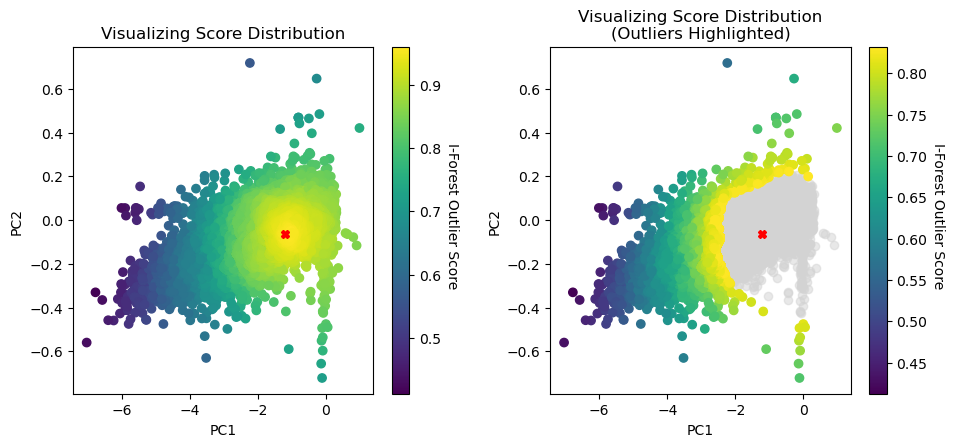

In [40]:
### Setting up the gridspec subplots
fig = plt.figure(figsize=(11,4.5))
grid = plt.GridSpec(1,11, wspace=0.4, hspace=0.8)

plot1 = fig.add_subplot(grid[0:5])
plot2 = fig.add_subplot(grid[6:])
axes = [plot1, plot2]

### Set up the data
combined = pd.concat([pd_df2, df_normal2], axis=0)#.sample(frac=0.25)
df_normal3 = df_normal2#.sample(frac=0.25)
pd_df3 = pd_df2#.sample(frac=0.25)

### Plot with a regular colormap
main_plt = plot1.scatter(combined["recon_PC1"], combined["recon_PC2"], c=combined["score"], cmap="viridis")
plot1.plot(mean_pc1, mean_pc2, "rX")
plot1.set(title="Visualizing Score Distribution", xlabel="PC1", ylabel="PC2") 
plot1.text(3.5, -0.3, "I-Forest Outlier Score", fontsize=10, rotation=270)
plt.colorbar(main_plt)

normal_plt = plot2.scatter(df_normal3["recon_PC1"], df_normal3["recon_PC2"], color="lightgrey", alpha=0.5)
main_plt = plot2.scatter(pd_df3["recon_PC1"], pd_df3["recon_PC2"], c=pd_df3["score"], cmap="viridis")
plot2.plot(mean_pc1, mean_pc2, "rX")
plot2.set(title="Visualizing Score Distribution\n(Outliers Highlighted)", xlabel="PC1", ylabel="PC2") 
plot2.text(3.75, -0.3, "I-Forest Outlier Score", fontsize=10, rotation=270)
plt.colorbar(main_plt)

plt.show()

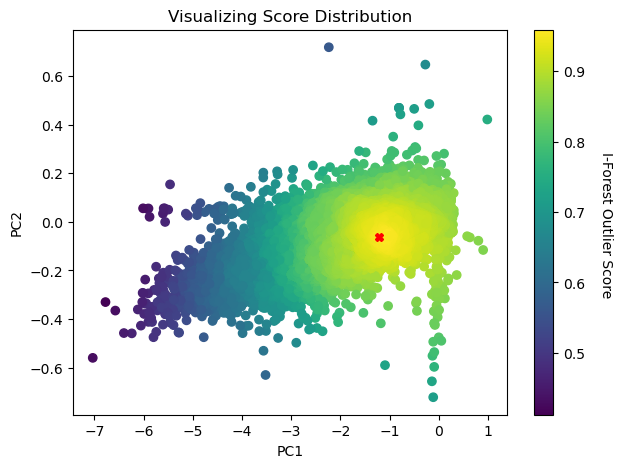

In [41]:
### Plot with a regular colormap

fig,ax = plt.subplots(1,1, figsize=(7,5))
combined = pd.concat([pd_df2, df_normal2], axis=0)#.sample(n=100000)
main_plt = ax.scatter(combined["recon_PC1"], combined["recon_PC2"], c=combined["score"], cmap="viridis")
ax.plot(mean_pc1, mean_pc2, "rX")
ax.set(title="Visualizing Score Distribution", xlabel="PC1", ylabel="PC2") 
plt.text(3.25, -0.3, "I-Forest Outlier Score", fontsize=10, rotation=270)
plt.colorbar(main_plt)
plt.show()

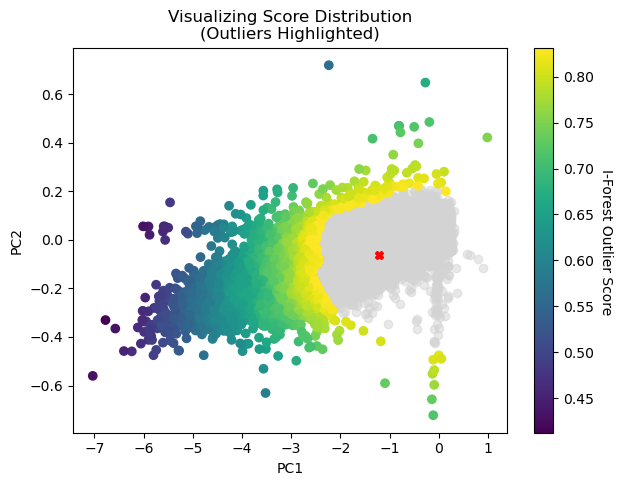

In [42]:
### Plot with discretized scores

fig,ax = plt.subplots(1,1, figsize=(7,5))
normal_plt = ax.scatter(df_normal2["recon_PC1"], df_normal2["recon_PC2"], color="lightgrey", alpha=0.5)
main_plt = ax.scatter(pd_df2["recon_PC1"], pd_df2["recon_PC2"], c=pd_df2["score"], cmap="viridis")
ax.plot(mean_pc1, mean_pc2, "rX")
ax.set(title="Visualizing Score Distribution\n(Outliers Highlighted)", xlabel="PC1", ylabel="PC2") 
plt.text(3.25, -0.3, "I-Forest Outlier Score", fontsize=10, rotation=270)
plt.colorbar(main_plt)
plt.show()

In [6]:
df1 = df_base.select("id", "ss_id", "stamp_date", "power_kW_values", "reconstructions", "recon_PC1", "recon_PC2")
df2 = df.select("id", F.col(mean_col).alias("score"))

df_joined = df1.join(df2, on="id", how="inner")

df_joined.show(1)

+---+-----+----------+--------------------+--------------------+---------+---------+------------------+
| id|ss_id|stamp_date|     power_kW_values|     reconstructions|recon_PC1|recon_PC2|             score|
+---+-----+----------+--------------------+--------------------+---------+---------+------------------+
|964| 2459|2016-04-29|[0.0, 0.0, 0.0, 0...|[0.0, 0.0, 0.0, 0...|      0.0|      0.0|0.8966066666666667|
+---+-----+----------+--------------------+--------------------+---------+---------+------------------+
only showing top 1 row



In [10]:
%%time
### Visualize average curves within each anomaly group (rounded to nearest .1) vs non-outliers
assemble_power = VectorAssembler(inputCols = [f"power_kW_values[{i}]" for i in range(0,48)], outputCol="power_kW_values2")
assemble_recon = VectorAssembler(inputCols = [f"reconstructions[{i}]" for i in range(0,48)], outputCol="reconstructions2")
# summarizer = Summarizer.metrics("mean")

df_normal = df_joined.select("id", "power_kW_values", "reconstructions", "score") \
              .where(F.col("score") >= score_cutoff) \
              .withColumn("score", F.round(F.round(F.col("score") * 2, 1)/2, 2))
df_outlier = df_joined.select("id", "power_kW_values", "reconstructions", "score") \
               .where(F.col("score") < score_cutoff) \
               .withColumn("score", F.round(F.round(F.col("score") * 2, 1)/2, 2))

### Calculate normal curve mean power/recon
df_normal = assemble_power.transform(df_normal.select("*", *(F.col("power_kW_values").getItem(i) for i in range(0,48))))
df_normal = assemble_recon.transform(df_normal.select("*", *(F.col("reconstructions").getItem(i) for i in range(0,48))))
df_normal = df_normal.select("id", "power_kW_values2", "reconstructions2", "score")
df_normal.show(5)

normal_mean_powers = df_normal.groupBy("score").agg(Summarizer.mean(F.col("power_kW_values2")).alias("mean_power"))
normal_mean_recons = df_normal.groupBy("score").agg(Summarizer.mean(F.col("reconstructions2")).alias("mean_recon"))

### Calculate outlier curve mean power/recon (grouped by outlier score)
df_outlier = assemble_power.transform(df_outlier.select("*", *(F.col("power_kW_values").getItem(i) for i in range(0,48))))
df_outlier = assemble_recon.transform(df_outlier.select("*", *(F.col("reconstructions").getItem(i) for i in range(0,48))))
df_outlier = df_outlier.select("id", "power_kW_values2", "reconstructions2", "score")
df_outlier.show(5)

outlier_mean_powers = df_outlier.groupBy("score").agg(Summarizer.mean(F.col("power_kW_values2")).alias("mean_power"))
outlier_mean_recons = df_outlier.groupBy("score").agg(Summarizer.mean(F.col("reconstructions2")).alias("mean_recon"))

+----+--------------------+--------------------+-----+
|  id|    power_kW_values2|    reconstructions2|score|
+----+--------------------+--------------------+-----+
| 964|          (48,[],[])|          (48,[],[])|  0.9|
|2214|(48,[16,17,18,19,...|[-7.7612569255096...|  0.9|
|2453|(48,[15,16,17,18,...|[-0.0112027525318...| 0.85|
|4590|[0.0,0.0,0.0,0.0,...|[0.00988028907622...|  0.9|
|4823|(48,[18,19,20,21,...|[0.00274011271349...|  0.9|
+----+--------------------+--------------------+-----+
only showing top 5 rows

+-----+--------------------+--------------------+-----+
|   id|    power_kW_values2|    reconstructions2|score|
+-----+--------------------+--------------------+-----+
| 8075|(48,[12,13,14,15,...|[-0.0012342951432...|  0.7|
|15371|(48,[9,10,11,12,1...|[-0.0080371676819...| 0.75|
|17043|(48,[9,10,11,12,1...|[-0.0011702152917...| 0.75|
|30025|[0.0,0.0,0.0,0.0,...|[0.01807957687517...|  0.8|
|51709|(48,[10,11,12,13,...|[-0.0031832806158...|  0.8|
+-----+--------------------+----

In [11]:
normal_mean_power_df = normal_mean_powers.toPandas()
normal_mean_recon_df = normal_mean_recons.toPandas()
outlier_mean_power_df = outlier_mean_powers.toPandas()
outlier_mean_recon_df = outlier_mean_recons.toPandas()

In [12]:
### Combining normal dfs
normal_df = pd.merge(normal_mean_power_df, normal_mean_recon_df, how="inner", on="score") \
               .sort_values("score", ascending=False) \
               .reset_index(drop=True)

### Combining outlier dfs
outlier_df = pd.merge(outlier_mean_power_df, outlier_mean_recon_df, how="inner", on="score") \
               .sort_values("score", ascending=False) \
               .reset_index(drop=True)

normal_df

,score,mean_power,mean_recon
0,0.95,"[1.487619296026984e-05, 1.4221930017883914e-05...","[-0.00042922112302828957, -0.00025049472359343..."
1,0.90,"[1.7046657174549553e-05, 1.5593125270465582e-0...","[-0.00011295595576188637, -9.029326818238127e-..."
2,0.85,"[1.4445617501187746e-05, 1.5681738488866248e-0...","[0.0014165036199972195, 0.0008874139454776581,..."


Number of normal groupings: 10


Text(0.5, 0.98, 'Average Reconstruction Curves of Normal Points\n(Grouped by Score Rounded to Nearest 0.5)')

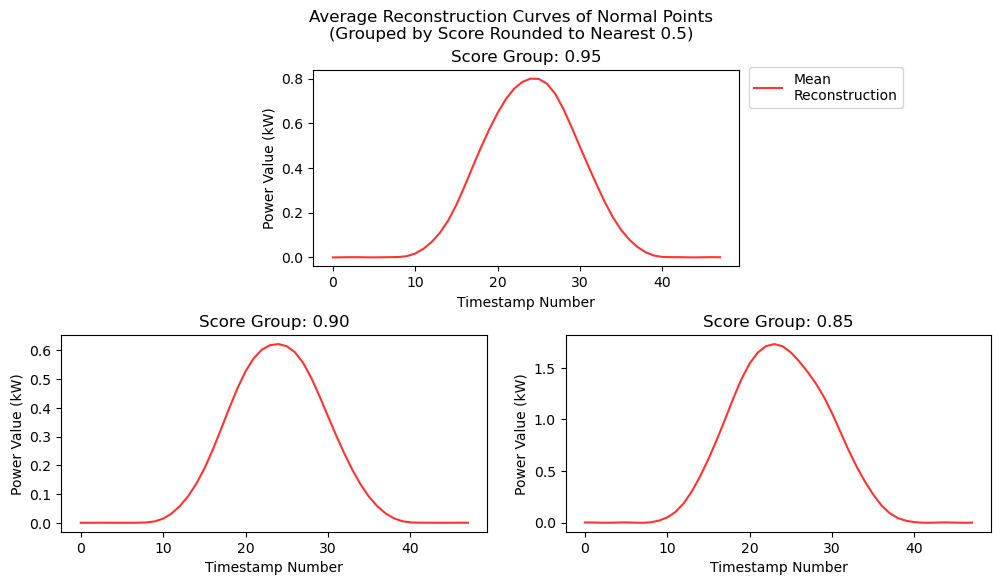

In [59]:
### Setting up the x range
x = [i for i in np.arange(0,48)]

### Setting up the gridspec subplots
fig = plt.figure(figsize=(12,6))
grid = plt.GridSpec(2,4, wspace=0.45, hspace=0.35)

plot1 = fig.add_subplot(grid[0,1:3])
plot2 = fig.add_subplot(grid[1,0:2])
plot3 = fig.add_subplot(grid[1,2:])
axes = [plot1, plot2, plot3]

### Plotting normal curves
print("Number of normal groupings:", len(outlier_df))

for i,ax in enumerate(axes):
    power = normal_df["mean_power"][i].values
    recon = normal_df["mean_recon"][i].values
    ax.plot(x, recon, "r", alpha=0.8, label="Mean\nReconstruction")
    ax.set(xlabel="Timestamp Number", ylabel="Power Value (kW)", title=f"Score Group: {normal_df['score'][i]:.2f}")
    if i==0:
        ax.legend(loc="upper right", bbox_to_anchor=([1.4, 1.05]))

plt.suptitle("Average Reconstruction Curves of Normal Points\n(Grouped by Score Rounded to Nearest 0.5)")

Number of outlier groupings: 10


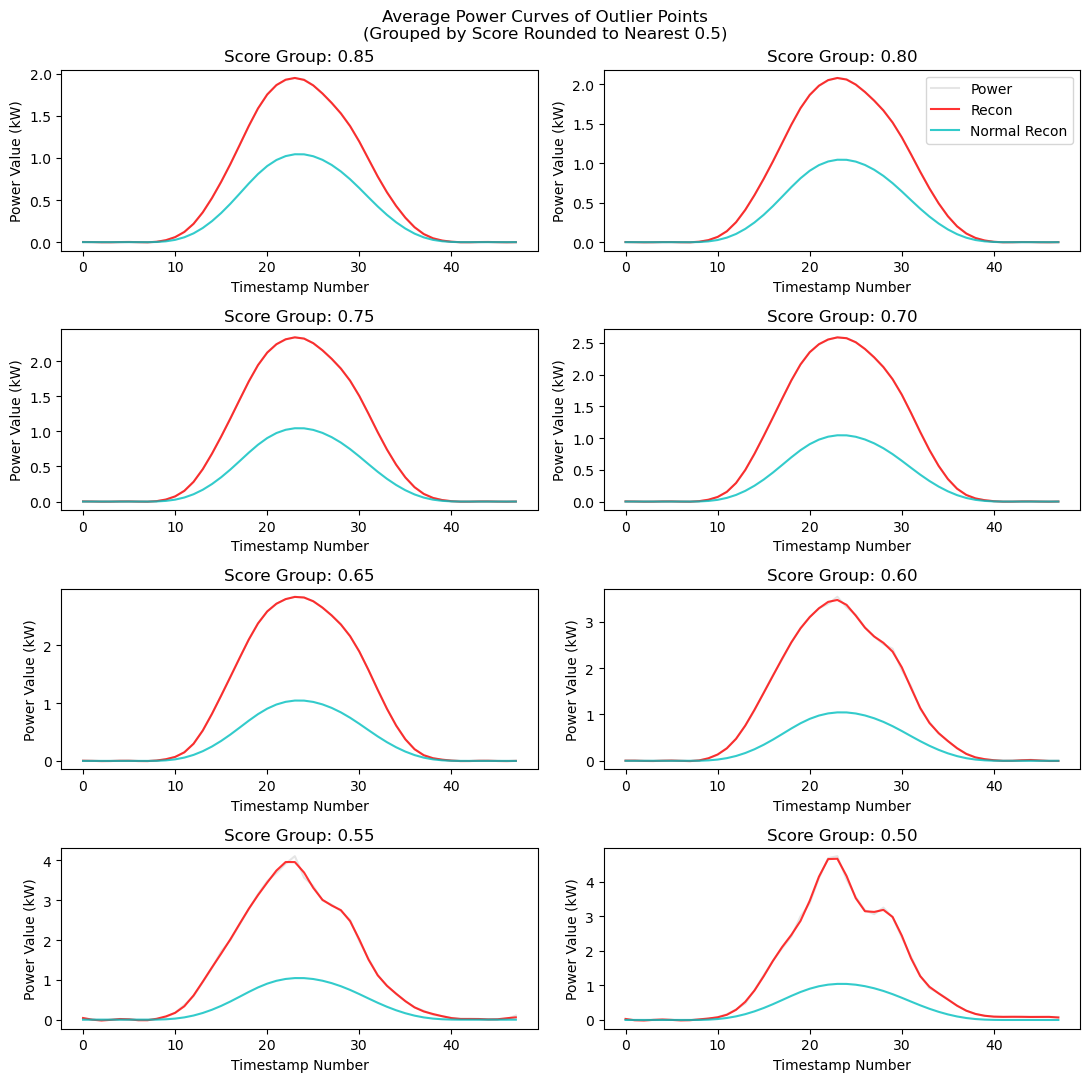

In [63]:
### Plotting outlier curves
print("Number of outlier groupings:", len(outlier_df))
normal_recon = np.array(normal_df["mean_recon"].tolist()).mean(axis=0)

fig,axes = plt.subplots(4,2, figsize=(11,11))
for i,ax in enumerate(axes.flatten()):
    power = outlier_df["mean_power"][i].values
    recon = outlier_df["mean_recon"][i].values

    ax1 = ax.plot(x, power, "k", alpha=0.1, label="Power")
    ax2 = ax.plot(x, recon, "r", alpha=0.8, label="Recon")
    ax3 = ax.plot(x, normal_recon, "c", alpha=0.8, label="Normal Recon")
    ax.set(xlabel="Timestamp Number", ylabel="Power Value (kW)", title=f"Score Group: {outlier_df['score'][i]:.2f}")
    if i==1:
        ax.legend()
plt.suptitle("Average Power Curves of Outlier Points\n(Grouped by Score Rounded to Nearest 0.5)")
plt.tight_layout()


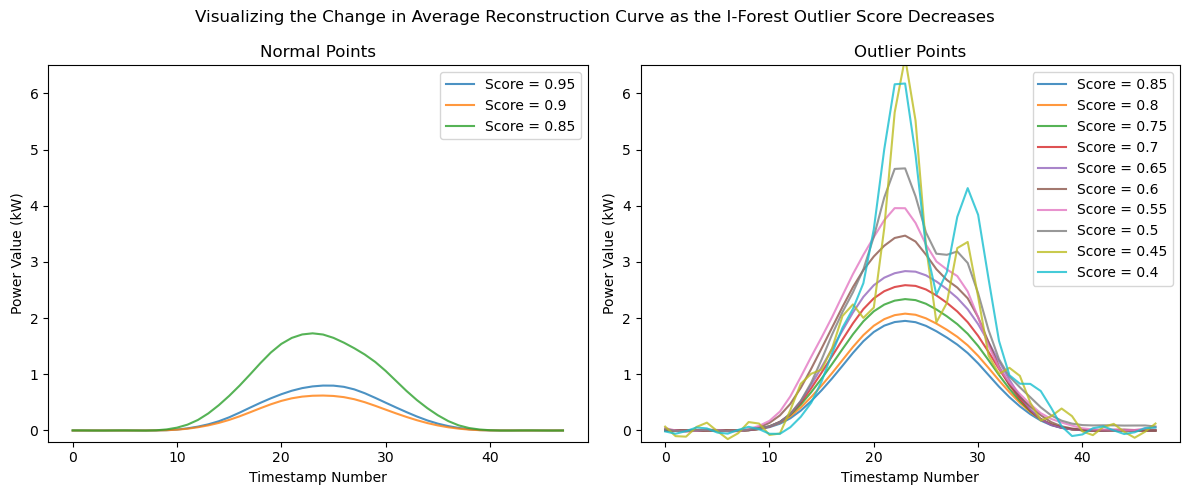

In [64]:
### Plotting the normal power curves

fig,ax = plt.subplots(1,2, figsize=(12,5))
for i in range(0,len(normal_df)):
    recon = normal_df["mean_recon"][i].values
    score = normal_df["score"][i]

    ax[0].plot(x, recon, alpha=0.8, label=f"Score = {score}")
    ax[0].set(xlabel="Timestamp Number", ylabel="Power Value (kW)", title="Normal Points", ylim=[-.2,6.5])
    ax[0].legend()

for i in range(0, len(outlier_df)):
    recon = outlier_df["mean_recon"][i].values
    score = outlier_df["score"][i]

    ax[1].plot(x, recon, alpha=0.8, label=f"Score = {score}")
    ax[1].set(xlabel="Timestamp Number", ylabel="Power Value (kW)", title="Outlier Points", ylim=[-.2,6.5])
    ax[1].legend()
    
plt.suptitle("Visualizing the Change in Average Reconstruction Curve as the I-Forest Outlier Score Decreases")
plt.tight_layout()

In [16]:
### Combining normal dfs
normal_df = pd.merge(normal_mean_power_df, normal_mean_recon_df, how="inner", on="score") 
normal_df["type"] = "Normal"
### Combining outlier dfs
outlier_df = pd.merge(outlier_mean_power_df, outlier_mean_recon_df, how="inner", on="score") 
outlier_df["type"] = "Outlier"
### Drop the 0.85 curve as it overlaps with the normal curve
outlier_df = outlier_df[outlier_df["score"]!=0.85]
### Combining both dfs
both_df = pd.concat([normal_df, outlier_df], axis=0) \
            .sort_values(["score", "type"], ascending=[True, False]) \
            .reset_index(drop=True)

x = [i for i in np.arange(0,48)]

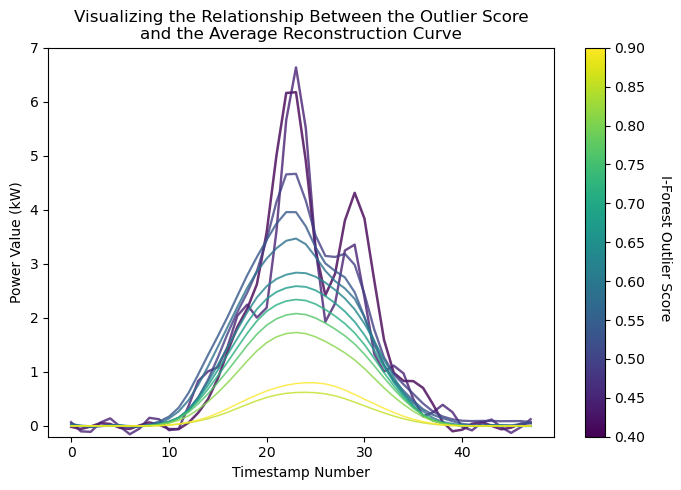

In [17]:
### Plotting the normal power curves

### Getting the colormap
colors = plt.colormaps["viridis"](np.linspace(0,1,len(both_df)))
### Prep the figure/axis
fig,ax = plt.subplots(1,1, figsize=(7,5))
### Prep the colorbar by setting up a fake plot, then clearing the axis
color_i = np.arange(both_df["score"].min(),both_df["score"].max(),0.05)
color_ax = ax.scatter(color_i, color_i, c=color_i, cmap="viridis")
ax.set_ylabel("I-Forest Outlier Score")
ax.yaxis.set_label_position("right")
fig.colorbar(color_ax, ticks=color_i)
plt.cla()

for i in range(0,len(both_df)):
    recon = both_df["mean_recon"][i].values
    score = both_df["score"][i]
    score_type = both_df["type"][i]

    ax.plot(x, recon, alpha=0.8, label=f"{score_type}_Score = {score}", color=colors[i], linewidth=np.exp(1-score)*1)
    ax.set(xlabel="Timestamp Number", ylabel="Power Value (kW)", 
              title="Visualizing the Relationship Between the Outlier Score\nand the Average Reconstruction Curve", 
              ylim=[-.2,7])

plt.text(60, 2, "I-Forest Outlier Score", fontsize=10, rotation=270)
plt.tight_layout()

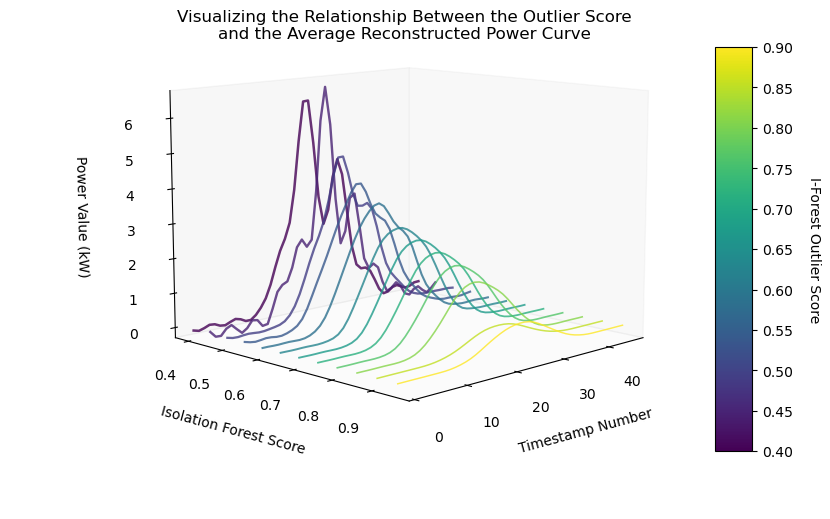

In [346]:
### Get a 3D version for easier visualization

### Setting up the gridspec subplots
fig = plt.figure(figsize=(12,6))
grid = plt.GridSpec(8,20, wspace=0.25, hspace=0.0)

plot_buffer = fig.add_subplot(grid[:,0])
plot_3d = fig.add_subplot(grid[:-2,2:15], projection="3d")
plot_cbar = fig.add_subplot(grid[:-1,15])

### Clear the buffer
plot_buffer.axis("off")

### Getting the colormap
colors = plt.colormaps["viridis"](np.linspace(0,1,len(both_df)))
### Prep the colorbar by setting up a fake plot, then clearing the axis
color_i = np.arange(both_df["score"].min(),both_df["score"].max(),0.05)
plt.scatter(color_i, color_i, c=color_i, cmap="viridis") ### Dummy plot
plt.colorbar(cax=plot_cbar, ticks=color_i)
plot_cbar.set_ylabel("I-Forest Outlier Score", rotation=270, labelpad=20)
plot_cbar.yaxis.set_label_position("right")

### Plot the 3d plot
for i in range(0,len(both_df)):
    recon = both_df["mean_recon"][i].values
    score = both_df["score"][i]
    score_type = both_df["type"][i]

    plot_3d.plot(x, recon, score, alpha=0.8, zdir="y", color=colors[i], linewidth=np.exp(1-score)*1, clip_on=False)

# Make axis "panes" transparent
plot_3d.xaxis.set_pane_color([.2,.2,.2,0.03])
plot_3d.yaxis.set_pane_color([.2,.2,.2,0.04])
plot_3d.zaxis.set_pane_color([.2,.2,.2,0.02])
plot_3d.grid(False)

# Set other values
plot_3d.set(xlabel="Timestamp Number", ylabel="Isolation Forest Score", xlim=([np.max(x), np.min(x)]),
      title="Visualizing the Relationship Between the Outlier Score\nand the Average Reconstructed Power Curve")
plot_3d.set_zlabel("Power Value (kW)", rotation=270)
plot_3d.set_box_aspect(aspect=None, zoom=1.5)
plot_3d.view_init(elev=10, azim=45, roll=0)
